# Be13, General Model, 3-sigma detection threshold

### basic info

In [1]:
from sparse_tools_F17 import *
from survey_params import *

model = 'Be13'

sphx_par = spherex_param()
dth = sphx_par.dth
nu_binedges = sphx_par.nu_binedges
nu_bins = sphx_par.nu_bins
line_use = ['Ha', 'OIII', 'Hb', 'OII', 'Lya']
line_name_arr = [r'$H\alpha$', r'$[O\, III]$', r'$H\beta$', r'$[O\, II]$', r'$Ly\alpha$']
nu0_arr = [spec_lines.Ha.to(u.GHz, equivalencies=u.spectral()).value,\
           spec_lines.OIII.to(u.GHz, equivalencies=u.spectral()).value,\
           spec_lines.Hb.to(u.GHz, equivalencies=u.spectral()).value,\
           spec_lines.OII.to(u.GHz, equivalencies=u.spectral()).value,\
           spec_lines.Lya.to(u.GHz, equivalencies=u.spectral()).value]
line_targ_vec = line_use

N_lc = 2500
line_targ_vec = line_use
dOm = (dth * u.arcmin.to(u.rad))**2

sigI0 = 3631 * 10**(-22  /2.5) / 5 / dOm / np.sqrt(4) # pixel NEI
sigI = sigI0 / np.sqrt(4)
e_th = sigI
sig_th = 3

N_sim = 100

In [2]:
with open('data_internal/sparse_be13_dict.pickle','rb') as pfile:
    A, I_norm, z_coords, N_nu, N_z, z_coords_all, z_idx, I_coords_all = pickle.load(pfile)

### Generate ligh cones

skip this cell

=================

In [3]:
N_true0, Itrue_all0, Itrue_targ0 = gen_lightcone(N_lc*4, dth, nu_binedges, z_coords_all, \
                      I_coords_all, z_idx, line_use, line_targ_vec, model = model)
N_true = N_true0[::4,:] + N_true0[1::4,:] + N_true0[2::4,:] + N_true0[3::4,:]
Itrue_all = (Itrue_all0[::4,:] + Itrue_all0[1::4,:] + Itrue_all0[2::4,:] + Itrue_all0[3::4,:]) / 4
Itrue_targ = (Itrue_targ0[:,::4,:] + Itrue_targ0[:,1::4,:] + Itrue_targ0[:,2::4,:]\
              + Itrue_targ0[:,3::4,:]) / 4
with open('data_internal/sparse_be13_general.pickle','wb') as pfile:
    pickle.dump([N_true, Itrue_all, Itrue_targ], pfile)

=================

In [3]:
with open('data_internal/sparse_be13_general.pickle','rb') as pfile:
    N_true, Itrue_all, Itrue_targ = pickle.load(pfile)

### run MP

skip this cell

=================

In [9]:
Ipred_targ_arr = np.zeros([N_sim]+list(Itrue_targ.shape))
for i in range(N_sim):
    Iobs_all = Itrue_all + np.random.normal(0, sigI, Itrue_all.shape)
    
    N_pred = run_MP_sig(A, I_norm / 4, Iobs_all, sigI, sig_th)
    
    _, Ipred_targ = gen_Ipred\
        (z_coords, N_pred, dth*2, nu_binedges, line_use, line_targ_vec, model = model, verbose = 0)
    Ipred_targ_arr[i] = Ipred_targ
    
    #print(i)
with open('data_internal/sparse_be13_general_sig.pickle','wb') as pfile:
    pickle.dump(Ipred_targ_arr,pfile)

=================

In [4]:
with open('data_internal/sparse_be13_general_sig.pickle','rb') as pfile:
    [Ipred_targ_arr] = pickle.load(pfile)

# Plot results

### VID

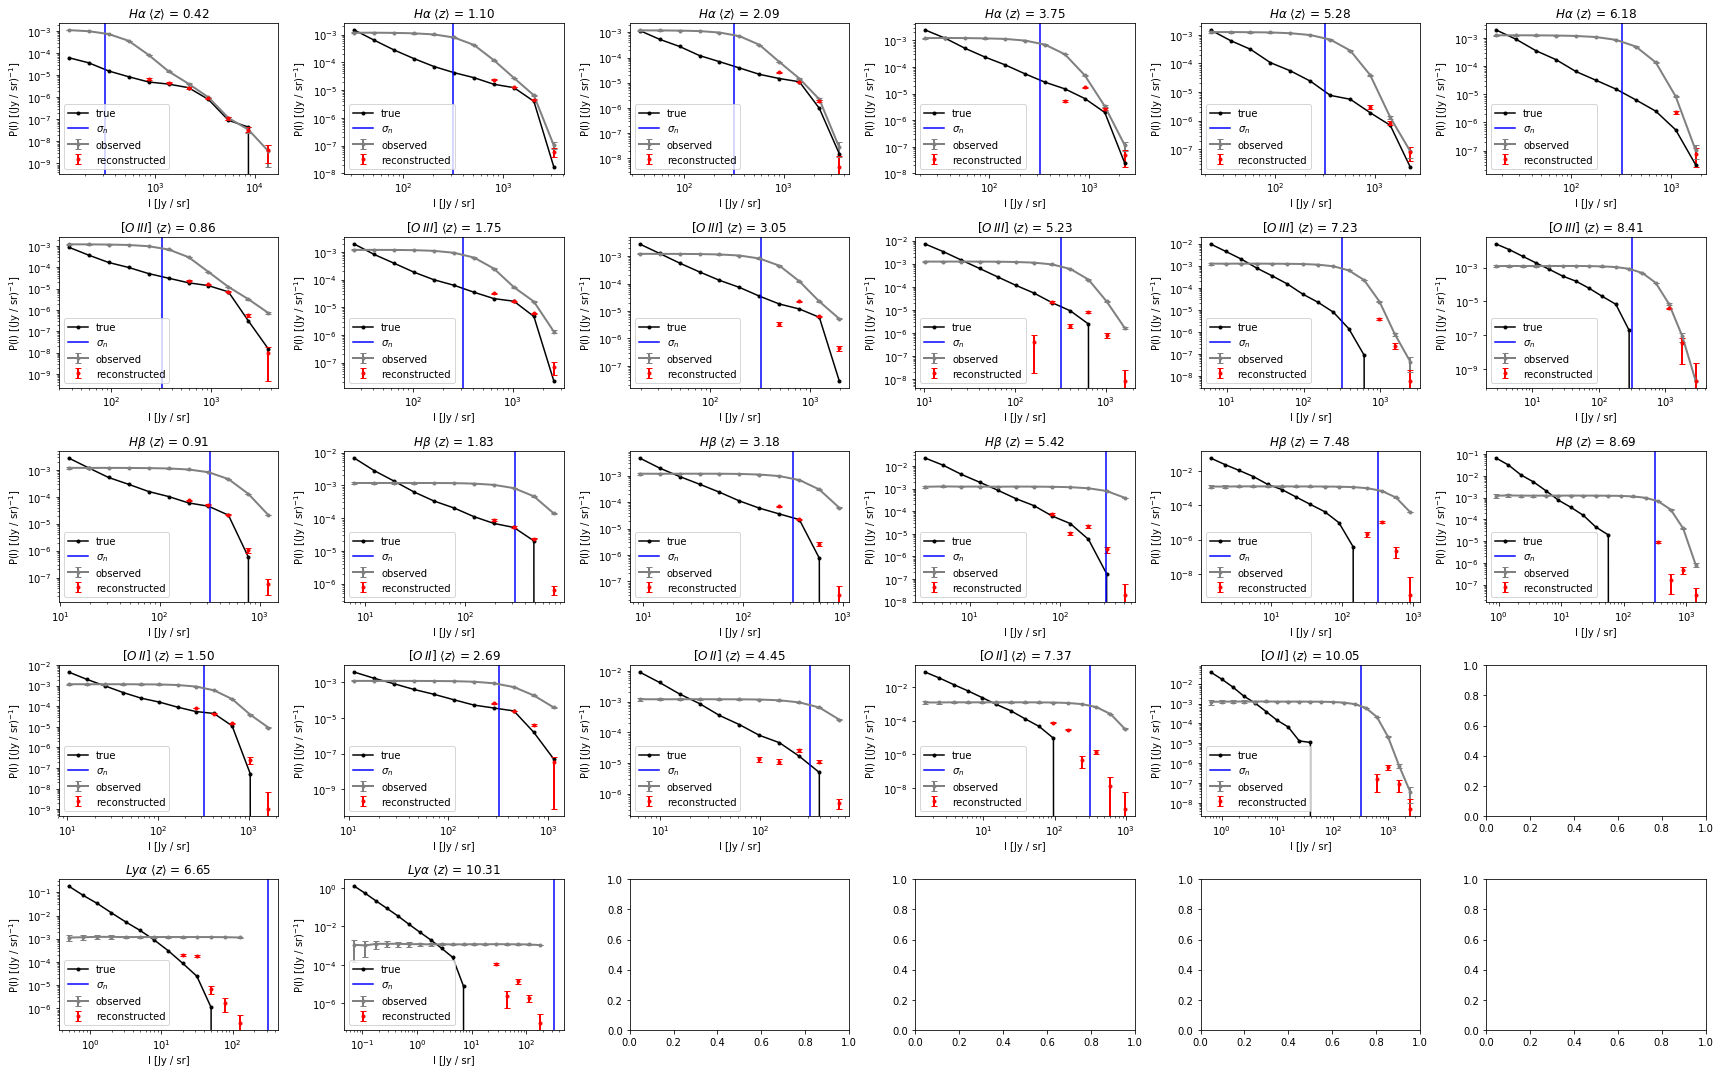

In [6]:
fig, ax = plt.subplots(5, 6, figsize = (24,15))
for line_idx in range(len(line_use)):
    line_name = line_name_arr[line_idx]
    zmin_arr = (nu0_arr[line_idx] / \
                (sphx_par.band_wlmin * u.um).to(u.GHz, equivalencies = u.spectral()).value) - 1
    zmax_arr = (nu0_arr[line_idx] / \
                (sphx_par.band_wlmax * u.um).to(u.GHz, equivalencies = u.spectral()).value) - 1
    zmid_arr = (zmin_arr + zmax_arr) / 2
    for band_idx in range(6):
        sp_band = sphx_par.broad_band_idx == band_idx
        dat_true = Itrue_targ[line_idx, :, sp_band].flatten()
        if not np.all(dat_true == 0):
            hmin = np.max(Itrue_targ[line_idx, :, sp_band]) / 100
            hmax1 = np.max(Ipred_targ_arr[:, line_idx, :, sp_band])
            hmax2 = np.max(Itrue_targ[line_idx, :, sp_band])
            hmax = max(hmax1, hmax2)
            Ibinedges = np.arange(np.log10(hmin),np.log10(hmax) + 0.2 ,0.2)
            Ibinedges = 10**Ibinedges
            I_all = (Ibinedges[1:] + Ibinedges[:-1]) / 2
            dIbins = Ibinedges[1:] - Ibinedges[:-1]
            
            h_true, _ = np.histogram(dat_true, bins = Ibinedges)
            h_true = h_true / len(dat_true) / dIbins
            ax[line_idx][band_idx].plot(I_all, h_true, 'k.-', label = 'true')

            #ax[line_idx][band_idx].plot(I_all, h_obs, '.-', c = 'grey', label = 'observed')

            h_pred_arr = np.zeros([N_sim, len(Ibinedges) - 1])
            h_obs_arr = np.zeros([N_sim, len(Ibinedges) - 1])
            for n_idx in range(N_sim):
                dat_pred = Ipred_targ_arr[n_idx, line_idx, :, sp_band].flatten()
                h_pred, _ = np.histogram(dat_pred, bins = Ibinedges)
                h_pred = h_pred / len(dat_pred) / dIbins
                h_pred_arr[n_idx, :] = h_pred
                
                Iobs_all = Itrue_all + np.random.normal(0, sigI, Itrue_all.shape)
                dat_obs = Iobs_all[:,sp_band].flatten()
                h_obs, _ = np.histogram(dat_obs, bins = Ibinedges)
                h_obs = h_obs / len(dat_obs) / dIbins
                h_obs_arr[n_idx, :] = h_obs

            ax[line_idx][band_idx].errorbar(I_all, np.mean(h_obs_arr, axis = 0), \
                                  np.std(h_obs_arr, axis = 0),  c = 'grey', \
                                  fmt = '.-', capsize = 3, lw = 2, label = 'observed')
            ax[line_idx][band_idx].errorbar(I_all, np.mean(h_pred_arr, axis = 0), \
                                  np.std(h_pred_arr, axis = 0),  c = 'r', \
                                  fmt = '.', capsize = 3, lw = 2, label = 'reconstructed')
            ax[line_idx][band_idx].axvline(sigI, c= 'b', ls = '-', label = '$\sigma_n$')
            ax[line_idx][band_idx].set_xscale('log')
            ax[line_idx][band_idx].set_yscale('log')
            ax[line_idx][band_idx].set_xlabel('I [Jy / sr]')
            ax[line_idx][band_idx].set_ylabel('P(I) [(Jy / sr)$^{-1}$]')
            ax[line_idx][band_idx].set_title(r'%s $\langle z \rangle$ = %.2f'\
                                             %(line_name, zmid_arr[band_idx]))
            ax[line_idx][band_idx].legend(loc = 0)
    plt.tight_layout()
plt.savefig('plots/paperfig/gen_VID.pdf', bbox_inches = 'tight', dpi = 300)

### Mean Intensity per Channel

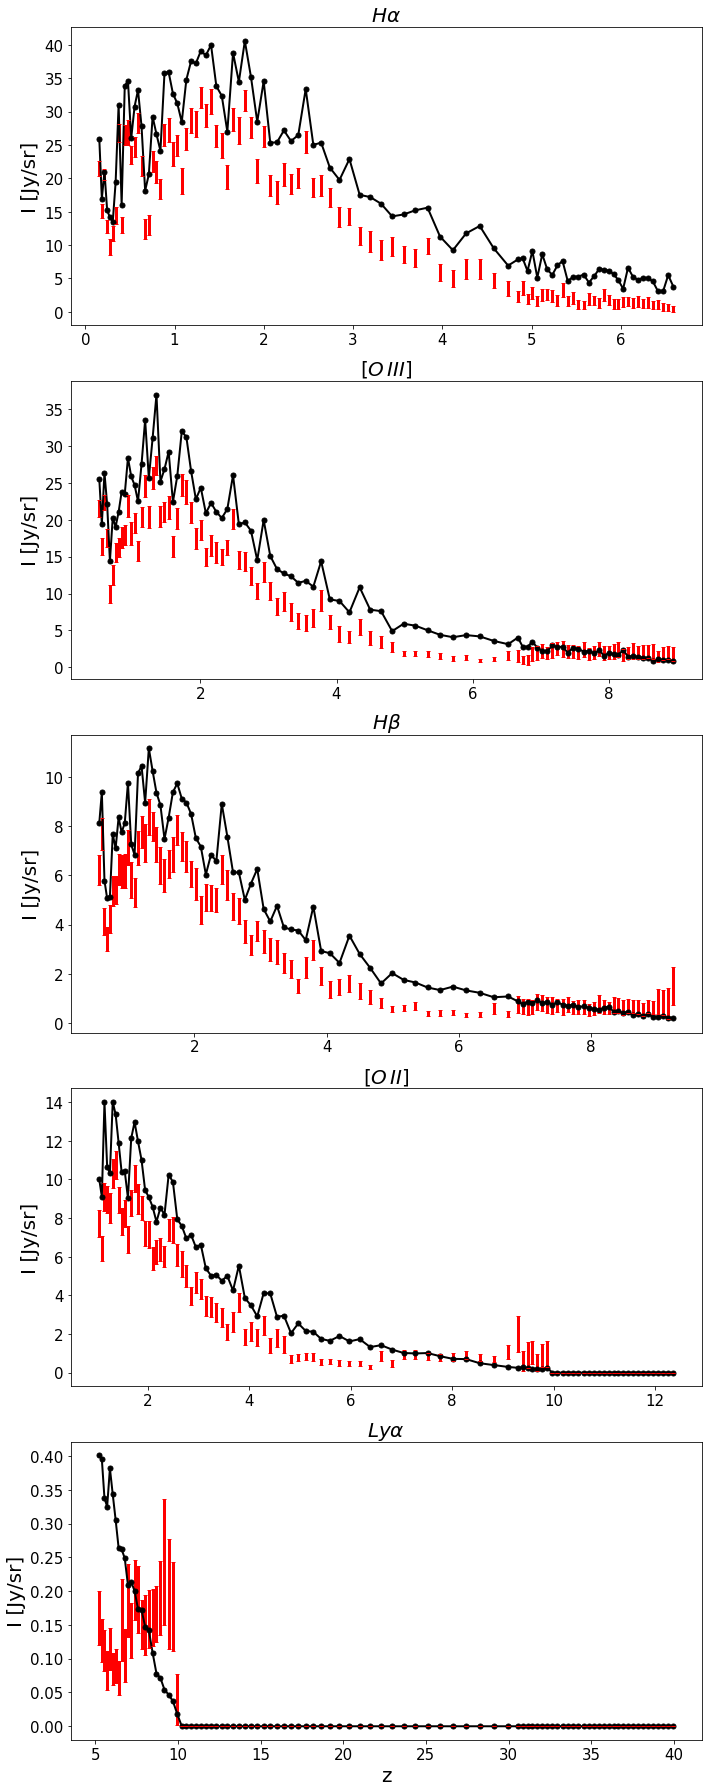

In [6]:
fig, ax = plt.subplots(5, 1, figsize = (10,25))

for jtarg, (nu0, line_name) in enumerate(zip(nu0_arr, line_name_arr)):
    zbins = nu0 / sphx_par.nu_bins - 1
    mu_true = np.mean(Itrue_targ[jtarg,:,:], axis=0)
    ax[jtarg].plot(zbins, mu_true, 'ko-', markersize = 5, lw = 2)
    
    mus_pred = np.mean(Ipred_targ_arr[:,jtarg,:,:], axis = 1)
    mu_pred = np.mean(mus_pred, axis = 0)
    sig = np.std(mus_pred, axis = 0)
    ax[jtarg].errorbar(zbins, mu_pred, sig, c = 'r', fmt = 'none', capsize = 2, lw = 3)
    ax[jtarg].set_title(line_name, fontsize = 20)
    ax[jtarg].tick_params(axis='both', which='major', labelsize=15)
    ax[jtarg].set_ylabel('I [Jy/sr]', fontsize = 20)
ax[4].set_xlabel('z', fontsize = 20)
fig.tight_layout()
#plt.savefig('plots/paperfig/gen_I.pdf', bbox_inches = 'tight', dpi = 300)

### Mean Intensity per band

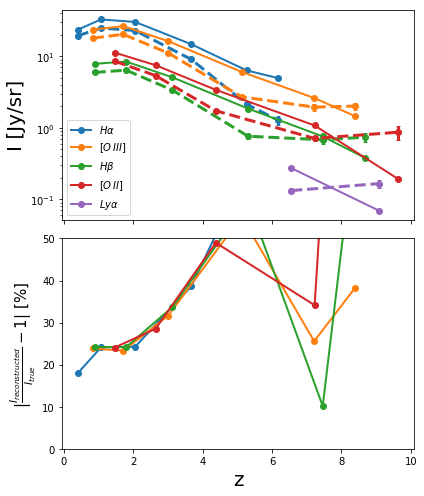

In [7]:
#
from matplotlib import gridspec

fig = plt.figure(figsize=[6,7])
gs = gridspec.GridSpec(2, 1, height_ratios=[1,1]) 
ax1= plt.subplot(gs[0])
ax2 = plt.subplot(gs[1], sharex = ax1)

for jtarg, (nu0, line_name,i,j) in enumerate(zip(nu0_arr, line_name_arr,[0,0,0,1,1],[0,1,2,0,1])):
    zbins = nu0 / sphx_par.nu_bins - 1
    mu_true = np.mean(Itrue_targ[jtarg,:,:], axis=0)    
    mus_pred = np.mean(Ipred_targ_arr[:,jtarg,:,:], axis = 1)
    mu_pred = np.mean(mus_pred, axis = 0)
    sig = np.std(mus_pred, axis = 0)
    bz = []
    bmu_true = []
    bmu_pred = []
    bsig_pred = []
    for iband in range(6):
        band_zbins = zbins[16*iband:16*(iband+1)]
        band_mu_true = mu_true[16*iband:16*(iband+1)]
        band_mus_pred = mus_pred[:,16*iband:16*(iband+1)]
        sp = np.where(band_zbins < 10)[0]
        band_zbins = band_zbins[sp]
        band_mu_true = band_mu_true[sp]
        band_mus_pred = band_mus_pred[:,sp]
        if len(sp) != 0:
            bz.append(np.mean(band_zbins))
            bmu_true.append(np.mean(band_mu_true))
            band_mus_pred = np.mean(band_mus_pred, axis = 1)
            bmu_pred.append(np.mean(band_mus_pred))
            bsig_pred.append(np.std(band_mus_pred))
            err = (np.mean(band_mus_pred) - np.mean(band_mu_true)) / np.mean(band_mu_true)
#             print('%s, z = %.2f, Itrue = %.3f, Ipred = %.3f +- %.3f, err = %.2f%% '\
#                   %(line_use[jtarg],np.mean(band_zbins),np.mean(band_mu_true),\
#                     np.mean(band_mus_pred),np.std(band_mus_pred), err*100))
    line = ax1.plot(bz, bmu_true,'o-', lw = 2, label = line_name)
    ax1.errorbar(bz, bmu_pred, bsig_pred, c = line[0].get_color(), fmt = 'none', capsize = 2, lw = 3)
    ax1.plot(bz, bmu_pred, 'o--', c = line[0].get_color(), lw = 3)
    err_arr = (np.array(bmu_pred) - np.array(bmu_true)) / np.array(bmu_true)
    ax2.plot(bz, np.abs(err_arr) * 100, 'o-', lw = 2, label = line_name)
    
ax1.set_ylabel('I [Jy/sr]', fontsize = 20)
ax1.tick_params(axis='both', which='major', labelsize=10)
plt.setp(ax1.get_xticklabels(), visible=False)
ax1.set_yscale('log')
ax1.legend(loc = 0, fontsize = 10)
ax2.set_xlabel('z', fontsize = 20)
ax2.set_ylabel(r'$|\frac{I_{reconstructed}}{I_{true}} - 1|$ [%]', fontsize = 15)
ax2.tick_params(axis='both', which='major', labelsize=10)
ax2.set_ylim([0,50])

plt.subplots_adjust(hspace=.0)
fig.tight_layout()
#plt.savefig('plots/paperfig/gen_I_band.pdf', bbox_inches = 'tight', dpi = 300)

### Map Visualization

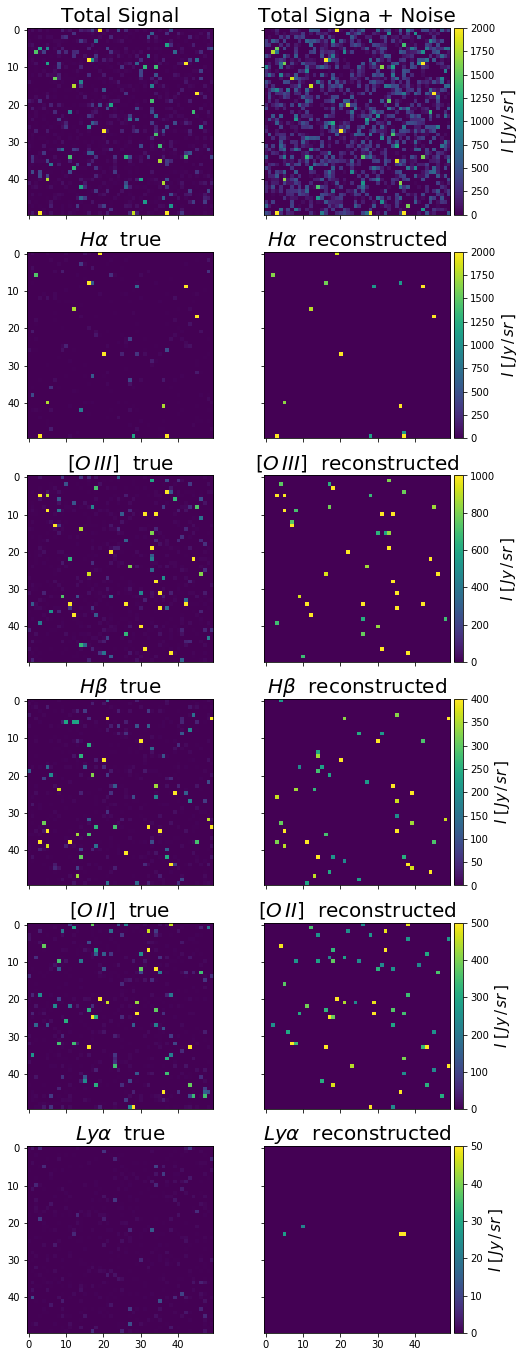

In [8]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

fig, ax = plt.subplots(6,2, figsize = (8,24))
img1 = ax[0][0].imshow(Itrue_all[:,8].reshape(50,50), vmin = 0, vmax = 2000)
img2 = ax[0][1].imshow(Iobs_all[:,8].reshape(50,50), vmin = 0, vmax = 2000)
divider = make_axes_locatable(ax[0][1])
cax2 = divider.append_axes("right", size="5%", pad=0.05)
cbar = fig.colorbar(img2, cax=cax2)
cbar.set_label(r'$I\,\,[\,Jy\, /\, sr\,]$', fontsize = 15)
ax[0][0].set_title('Total Signal', fontsize = 20)
ax[0][1].set_title('Total Signa + Noise', fontsize = 20)
ax[0][1].get_yaxis().set_ticklabels([])
ax[0][0].get_xaxis().set_ticklabels([])
ax[0][1].get_xaxis().set_ticklabels([])
        
for i,vmax in enumerate([2000,1000,400,500,50]):
    img1 = ax[i+1][0].imshow(Itrue_targ[i,:,8].reshape(50,50), vmin = 0, vmax = vmax)
    img2 = ax[i+1][1].imshow(Ipred_targ_arr[-1,i,:,8].reshape(50,50), vmin = 0, vmax = vmax)
    divider = make_axes_locatable(ax[i+1][1])
    cax2 = divider.append_axes("right", size="5%", pad=0.05)
    cbar = fig.colorbar(img2, cax=cax2)
    cbar.set_label(r'$I\,\,[\,Jy\, /\, sr\,]$', fontsize = 15)
    ax[i+1][0].set_title(line_name_arr[i] + '  true', fontsize = 20)
    ax[i+1][1].set_title(line_name_arr[i] + '  reconstructed', fontsize = 20)
    ax[i+1][1].get_yaxis().set_ticklabels([])
    if i != len(line_use) - 1:
        ax[i+1][0].get_xaxis().set_ticklabels([])
        ax[i+1][1].get_xaxis().set_ticklabels([])

plt.savefig('plots/paperfig/gen_im.pdf', bbox_inches = 'tight', dpi = 300)

### Correlation Coeff

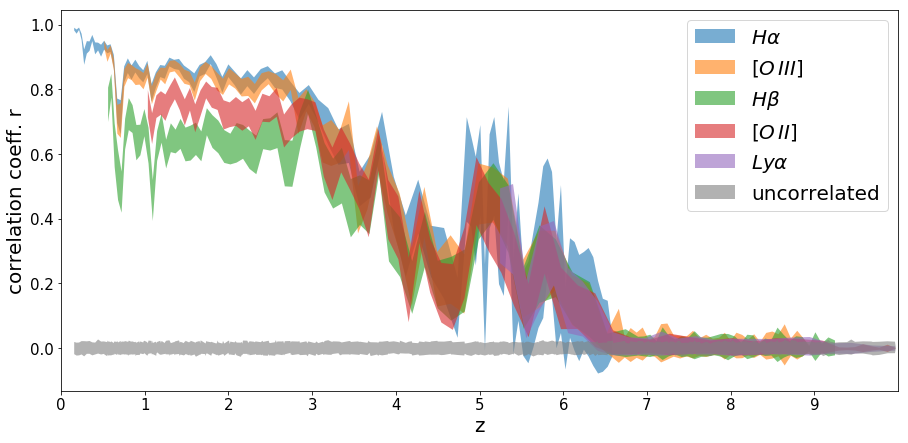

In [10]:
fig, ax = plt.subplots(1, 1, figsize = (15,7))

mucntot_arr = np.array([])
sigcntot_arr = np.array([])
ztot_arr = np.array([])
for jtarg in range(len(line_use)):
    nu0 = nu0_arr[jtarg]
    zbins = nu0 / sphx_par.nu_bins - 1
    sp = np.where(zbins < 10)[0]
    mucp_arr = np.zeros(N_nu)
    sigcp_arr = np.zeros(N_nu)
    mucn_arr = np.zeros(N_nu)
    sigcn_arr = np.zeros(N_nu)
    for iband in range(N_nu):
        cp_arr = np.zeros(Ipred_targ_arr.shape[0])
        cn_arr = np.zeros(Ipred_targ_arr.shape[0])
        for isim in range(Ipred_targ_arr.shape[0]):
            mapt = Itrue_targ[jtarg, :, iband]
            mapp = Ipred_targ_arr[isim, jtarg, :, iband]
            mapn = np.random.normal(size = mapt.shape)
            mapt -= np.mean(mapt)
            mapp -= np.mean(mapp)
            mapn -= np.mean(mapn)
            if np.sum(mapt**2) > 0 and np.sum(mapp**2) > 0:
                cp_arr[isim] = np.sum(mapt * mapp) / np.sqrt(np.sum(mapt**2) * np.sum(mapp**2))
            if np.sum(mapt**2) > 0 and np.sum(mapn**2) > 0:
                cn_arr[isim] = np.sum(mapt * mapn) / np.sqrt(np.sum(mapt**2) * np.sum(mapn**2))
        mucp_arr[iband] = np.mean(cp_arr)
        sigcp_arr[iband] = np.std(cp_arr)
        mucn_arr[iband] = np.mean(cn_arr)
        sigcn_arr[iband] = np.std(cn_arr)
        
    mucntot_arr = np.concatenate((mucntot_arr, mucn_arr[sp]))
    sigcntot_arr = np.concatenate((sigcntot_arr, sigcn_arr[sp]))
    ztot_arr = np.concatenate((ztot_arr, zbins[sp]))
    ax.fill_between(zbins[sp],mucp_arr[sp] - sigcp_arr[sp], mucp_arr[sp] + sigcp_arr[sp],\
                    label = line_name_arr[jtarg], alpha = 0.6)
sortidx = ztot_arr.argsort()
ax.fill_between(ztot_arr[sortidx], mucntot_arr[sortidx] - sigcntot_arr[sortidx],\
                mucntot_arr[sortidx] + sigcntot_arr[sortidx], alpha=0.6, \
                facecolor='gray', label = 'uncorrelated')
ax.legend(loc = 0, fontsize = 20)
ax.set_xlabel('z', fontsize = 20)
ax.set_xlim([0,10])
ax.set_ylabel(r'correlation coeff. r', fontsize = 20)
ax.set_xticks(np.arange(10))
ax.tick_params(axis='both', which='major', labelsize=15)

plt.savefig('plots/paperfig/gen_r.pdf', bbox_inches = 'tight', dpi = 300)